# 20.基于模型的策略优化 (model-based policy optimization，MBPO）
- **Dyna-Q** 算法中的模型只存储之前遇到的数据，只适用于 **表格型环境**；
- 在 **连续型** 状态和动作的环境中，若继续利用 **Dyna** 的思想，可以像 **PETS** 算法一样学习一个用 **神经网络环境模型**，然后在任意状态和动作下用 **环境模型** 来生成一些虚拟数据来帮助进行策略的学习；
- 如此，对 **真实环境** 中样本的需求量会减少，通常会比 **无模型** 的强化学习方法具有更高的采样效率 —— **MBPO** 算法。

## 20.1 MBPO 原理
> **加州大学伯克利分校 (UC Berkeley)** 的研究员在 2019 年的 NeurIPS 会议中提出 **MBPO** 算法 [When to Trust Your Model: Model-Based Policy Optimization](https://arxiv.org/abs/1906.08253) 

> 研究证明，在多个 **MuJoCo** 连续控制任务上，**MBPO** 的性能相比 **基于模型** 的方法更优，甚至在样本效率上超过了一些 **无模型算法**（如 **SAC**）
> **MBPO** 被认为是 **基于模型的强化学习领域中的里程碑式算法**，成为深度强化学习中最重要的**基于模型**的强化学习算法之一，不少之后的工作都是在此基础上进行的

> **MBPO** 算法基于 **两个关键** 的观察：
- 随着环境模型的 **推演步数** 变长，模型累积的 **复合误差** 会快速增加，使得环境模型得出的结果变得很 **不可靠**
- **推演步数** 必须要 **权衡**  *推演步数长，复合误差大* 的 **负面作用** 与 *推演步数长，训练策略更优* 的 **正面作用**
> 在这两个观察的基础之上提出了一种 **分支推演（branched rollout）**  的思想：*只使用环境模型 **从之前访问过的真实状态开始** 进行 **较短步数** 的推演，**而非**从初始状态开始进行**完整的推演**，**避免**长时间依赖预测，**减弱**模型误差累积的影响：*
![示意图](Illustrations/分支推演示意图.png)
- **分支推演的长度$k$** 是 **平衡** 样本效率和策略性能的 **重要超参数**

### *真实环境下策略性能提升的单调性保障*
> 基于模型的方法往往是在 **环境模型** 中提升策略的性能，但这并不能保证在 **真实环境** 中策略性能也有所提升，对此需要保证：

$$\eta[\pi]\geq\hat{\eta}[\pi]-\left[\frac{2\gamma r_{\max}(\epsilon_m+2\epsilon_\pi)}{(1-\gamma)^2}+\frac{4r_{\max}\epsilon_\pi}{(1-\gamma)}\right]$$
$$C=\left[\frac{2\gamma r_{\max}(\epsilon_m+2\epsilon_\pi)}{(1-\gamma)^2}+\frac{4r_{\max}\epsilon_\pi}{(1-\gamma)}\right]$$

- $\eta[\pi]$表示策略在 **真实环境** 中的 **期望回报**
- $\hat{\eta}[\pi]$表示策略在 **模型环境** 中的 **期望回报**
- $\epsilon_m$: **模型误差**，指模型在预测环境动态时的误差度量，代表着 **模型预测** 与 **真实环境状态转移**之间的差异（单步误差）
- $\epsilon_\pi$: **策略误差**，指策略执行时的误差度量，刻画了在 **同一当前策略$\pi$** 下，**模型预测的状态轨迹** 与 **真实轨迹** 之间的偏移（长期误差）

> 误差项的构造：
- $\frac{2\gamma r_{\max}(\epsilon_m + 2\epsilon_\pi)}{(1-\gamma)^2}$ 捕捉 **“模型不准 + 策略偏移”** 引起的长期累积误差
- $\frac{4r_{\max} \epsilon_\pi}{(1-\gamma)}$ 捕捉 **“即使模型准，但分布不同”** 造成的性能差
- 具体的推导过程见原论文附录 **Appendix A**

> 这意味着如果 **模型环境** 策略性能的提升可以超过 **performance bound（性能界/性能下界）$C$** ，理论上就可以在 **真实环境** 中取得策略性能的提升

### *模型推演长度*
> **MBPO** 对 **模型误差 $\epsilon_m$** 进行了优化：使用 **策略相关模型误差$\epsilon_{m'}$** ，关注 **当前策略$\pi$** 在 **有限步 rollout（推演片段）** 下可能访问的分布中与真实分布的最大差异，而不是将在 **环境模型** 上训练策略时所触及到的 **所有分布** 都考虑进来。
> 此时，两种误差都被局限在 **当前策略的有限步访问分布** 中，将两者结合起来，可更准确地估计策略在模型里的性能差异，从而指导安全的 **rollout步长$H$** 和 **策略优化**：
![策略偏移与模型误差](Illustrations/策略偏移与模型误差.png)

> 对 $\epsilon_m'$ 在 $\epsilon_\pi=0$ 附近做一阶展开：
$$\epsilon_m^{\prime}(\epsilon_\pi)\approx\epsilon_m^{\prime}|_{\epsilon_\pi=0}+\epsilon_\pi\frac{\mathrm{d}\epsilon_m^{\prime}}{\mathrm{d}\epsilon_\pi}$$
- 并不是数学上严格意义的泰勒一阶展开，而是一种 **改进的近似**，只是为了 **捕捉策略偏移对模型误差的增量影响**（直观作用类似一阶展开）
- 没有闭式表达式能把 $\epsilon_m'$ 精确写成 $\epsilon_\pi$ 的函数


> 当策略偏移为零时，**环境误差** 退化，考虑 **全局的分布**：
$$\epsilon_m^{\prime}(\epsilon_\pi)\approx\epsilon_m+\epsilon_\pi\frac{\mathrm{d}\epsilon_m^{\prime}}{\mathrm{d}\epsilon_\pi}.$$

> 再结合上 $k$ 步 **分支推演**，得到一个 **新的策略期望回报界**：
$$\eta[\pi]\geq\eta^\mathrm{branch}[\pi]-2r_\mathrm{max}\left[\frac{\gamma^{k+1}\epsilon_\pi}{(1-\gamma)^2}+\frac{\gamma^k\epsilon_\pi}{(1-\gamma)}+\frac{k}{1-\gamma}\epsilon_{m^{\prime}}\right]$$

- 具体的推导过程见原论文附录 **Appendix A**

> 此时，在策略误差一定时，当推演步数$H$变大，$\frac{\gamma^{k+1}\epsilon_\pi}{(1-\gamma)^2}+\frac{\gamma^k\epsilon_\pi}{(1-\gamma)}$减小
> 虽然$\frac{k}{1-\gamma}\epsilon_{m^{\prime}}$ 增大，但如果 **策略转移损害对模型准确度的影响$\frac{\mathrm{d}\epsilon_m^{\prime}}{\mathrm{d}\epsilon_\pi}$** 足够小（在主流的机器人运动环境 **Mojoco** 的典型场景中，其数量级非常小，大约都在$[10^{-4},10^{-2}]$）
> 那么就存在一个 **正推演步长$k$**，使 **策略提升** 有效。



> 需要注意的是，在高随机性的离散状态环境中，往往环境模型的拟合精度较低，以至于$\frac{\mathrm{d}\epsilon_m^{\prime}}{\mathrm{d}\epsilon_\pi}$较大，此时使用基于 **分支推演** 的方法 **效果有限**

## 20.2 MBPO 代码实践(Pendulum-v1)

1. **MBPO** 算法与 **Dyna-Q** 算法十分类似。但 **Dyna-Q** 采用的**无模型强化学习部分**是 **Q-learning**，而 **MBPO** 是基于 **SAC**
2. **MBPO** 算法关于 **环境模型的构建** 和 **PETS** 算法中一致，都使用 **模型集成** 的方式
3. **MBPO** 算法使用了 **模型生成的数据** 和 **真实环境的数据** 混合训练策略，提升了 **样本效率** 和 **稳定性**

导入相关库：

In [202]:
# 基本库
import numpy as np
import random

import itertools
import collections


# 神经网络
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions.normal import Normal
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

In [203]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

###  SAC 部分

*定义策略网络和价值网络:*

In [204]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        
        dist = Normal(mu, std)  # 构建高斯分布
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        # 动作范围映射
        action = torch.tanh(normal_sample)  # a=tanh(z) 
        action = action * self.action_bound
        # 概率密度的变量替换
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)  # 1-tanh(z)^2是tanh的导数（sech²），加1e-7避免log(0)
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

*定义 **SAC** 算法（连续动作）：*

In [205]:
class SACContinuous:
    """ 处理连续动作空间 """
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        # 双Q网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        
        # 使用温度参数alpha的log值,可以确保 α 永远是正数,使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau  # 软更新步长
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]
    
    # 计算目标Q值
    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 连续动作熵用动作采样的负对数概率近似
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target
    
    # DDPG中的软更新
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)


        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob  # 连续动作熵用动作采样的负对数概率近似
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标Q网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

### 集成环境模型构建(沿用 PETS 算法中的)

***激活函数定义：***

In [206]:
class Swish(nn.Module):
    """ Swish激活函数 """
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

***初始化网络层参数：***

In [207]:
def init_weights(m):  # m 为某个网络层
    """ 初始化模型权重 """
    def truncated_normal_init(t, mean=0.0, std=0.01):
        """ 截断正态分布 """
        torch.nn.init.normal_(t, mean=mean, std=std)  # 用均值为 mean、标准差为 std 的正态分布随机数填充张量t 
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            if not torch.sum(cond):  # 如果所有值都在范围内 (torch.sum(cond) == 0)，就退出循环
                break
            t = torch.where(
                cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),mean=mean,std=std), 
                t)  # 如果有越界的值，就重新采样，并用 torch.where 把这些位置替换成新的采样值
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):  # 若 m 是全连接层（nn.Linear）或 自定义层 FCLayer
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))  # 权重 m.weight 用截断正态分布初始化
        m.bias.data.fill_(0.0)  # 偏置 m.bias 全部设为 0

***自定义的全连接层：***

In [208]:
class FCLayer(nn.Module):
    """ 自定义的全连接层 (FCLayer)，支持 ensemble（集成） """
    # ensemble_size: 集成的个数（即同时训练多少组独立的参数）
    # activation: 激活函数（如 ReLU、Swish）
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self._activation = activation
        self.bias = nn.Parameter(torch.Tensor(ensemble_size, output_dim).to(device))

    def forward(self, x):
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))  # 矩阵计算
            # X:(ensemble_size, batch_size, input_dim)
            # W:(ensemble_size, input_dim, output_dim)
            # 偏置bias扩展到 (ensemble_size, batch_size, output_dim)

***集成环境模型定义：***

In [209]:
class EnsembleModel(nn.Module):
    """ 环境模型集成 """
    def __init__(self,
                 state_dim,
                 action_dim,
                 ensemble_size=5,  # 模型成员总数为ensemble_size，对应训练ensemble_size组权重
                 learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        self._output_dim = (state_dim + 1) * 2  # 预测奖励与状态增量 以及 对应方差
        # 方差上界和下界
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),
                                        requires_grad=False)
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),
                                        requires_grad=False)
        # 集成模型中每个成员为5层神经网络
        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size, Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size, nn.Identity())  # nn.Identity()，原样返回输入
        self.apply(init_weights)  # 对所有 nn.Linear 和 FCLayer 层做权重初始化
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, return_log_var=False):  # 选择是否返回对数方差
        # 前向传播
        ret = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        # 输出一分为二
        mean   = ret[:, :, :self._output_dim // 2]   # 前一半 -> 均值
        raw_lv = ret[:, :, self._output_dim // 2:]   # 后一半 -> 原始对数方差 logvar（未约束）
        # 使用softplus函数,将方差控制在最小值和最大值之间
        logvar = self._max_logvar - F.softplus(self._max_logvar - raw_lv)
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, mean, logvar, labels, use_var_loss=True):  # 是否选择带方差的 loss
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            # 对应简化损失函数
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) * inverse_var,
                                             dim=-1),dim=-1)
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            # 退化为普通的 MSE
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train_my(self, loss):
        self.optimizer.zero_grad()
        # 惩罚 _max_logvar 太大；惩罚 _min_logvar 太小
        loss += 0.01 * torch.sum(self._max_logvar) - 0.01 * torch.sum(self._min_logvar)
        loss.backward()
        self.optimizer.step()

***模型的训练：***

In [210]:
class EnsembleDynamicsModel:
    def __init__(self, state_dim, action_dim, num_network=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim,
                                   action_dim,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0  # 在 5 次没有获得表现提升时就结束训练
        # 记录每个网络的最佳 epoch 和对应验证集损失，用于早停和选择最优模型
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}

    # 模型成员并行训练
    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集，holdout_ratio 默认为 0.1，即 10% 数据用于验证
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]  # 训练集：90%
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[:num_holdout]  # 验证集：10%
        # 复制验证集数据，使每个网络都能独立计算损失
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        holdout_inputs = holdout_inputs[None, :, :].repeat([self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat([self._num_network, 1, 1])

        # itertools.count() 会无限产生整数：0,1,2,… ；实际训练结束条件在循环内部通过 _save_best 和 epoch > max_iter 来控制
        for epoch in itertools.count():  # itertools.count() 会无限产生整数：0,1,2,…
            # 为每个模型成员生成独立的训练顺序（认知不确定性）
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])
            # Mini-batch 训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):  # 按 batch_size 分块，逐个 batch 进行训练
                batch_index = train_index[:, batch_start_pos:batch_start_pos +batch_size]
                train_input = torch.from_numpy(train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(train_labels[batch_index]).float().to(device)

                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)
                self.model.train_my(loss)
                
            # 用验证集评估 Mini-batch训练后 模型的性能
            with torch.no_grad():  # 在其作用域内禁止梯度计算
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(mean,
                                                    logvar,
                                                    holdout_labels,
                                                    use_var_loss=False)
                holdout_losses = holdout_losses.cpu()  # GPU 张量不能直接用于大多数 Python 操作
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        updated = False  # 标记本轮是否有网络取得了显著改进
        for i in range(len(losses)):
            current = losses[i]
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, inputs, batch_size=64):
        inputs = np.tile(inputs, (self._num_network, 1, 1))
        inputs = torch.tensor(inputs, dtype=torch.float).to(device)
        mean, var = self.model(inputs, return_log_var=False)
        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()

> 修改部分:
- def predict

***定义模拟环境 FakeEnv，用训练好的 EnsembleDynamicsModel 来预测下一状态和奖励：***

In [211]:
class FakeEnv:
    def __init__(self, model):
        self.model = model

    def step(self, obs, act):
        inputs = np.concatenate((obs, act), axis=-1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)  
        # (num_network, n_states, mean)
        ensemble_model_means[:, :, 1:] += obs  # 当前状态+预测的状态增量，变为下一状态
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        # 得出每个模型成员的预测结果并使用高斯采样
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds

        num_models, batch_size, _ = ensemble_model_means.shape
        # 为每一个状态的下一步预测使用随机的模型成员
        models_to_use = np.random.choice([i for i in range(self.model._num_network)], size=batch_size)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        # batch_size中每个状态都随机采用了某个模型成员进行预测（相应的奖励以及下一个状态）
        rewards, next_obs = samples[:, :1][0][0], samples[:, 1:][0]
        return rewards, next_obs


> 修改部分:
- def step

### 经验回放池Replay Buffer

In [212]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            return self.return_all_samples()
        else:
            transitions = random.sample(self.buffer, batch_size)
            state, action, reward, next_state, done = zip(*transitions)
            return np.array(state), np.array(action), reward, np.array(next_state), done

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

### MBPO 算法

In [213]:
class MBPO:
    def __init__(self, env, agent, fake_env, env_pool, model_pool,
                 rollout_length, rollout_batch_size, real_ratio, num_episode):

        self.env = env
        self.agent = agent
        self.fake_env = fake_env
        self.env_pool = env_pool
        self.model_pool = model_pool
        self.rollout_length = rollout_length
        self.rollout_batch_size = rollout_batch_size
        self.real_ratio = real_ratio
        self.num_episode = num_episode

    def rollout_model(self):
        observations, _, _, _, _ = self.env_pool.sample(self.rollout_batch_size)
        for obs in observations:
            for i in range(self.rollout_length):
                action = self.agent.take_action(obs)
                reward, next_obs = self.fake_env.step(obs, action)
                self.model_pool.add(obs, action, reward, next_obs, False)
                obs = next_obs

    def update_agent(self, policy_train_batch_size=64):
        env_batch_size = int(policy_train_batch_size * self.real_ratio)
        model_batch_size = policy_train_batch_size - env_batch_size
        for epoch in range(10):
            env_obs, env_action, env_reward, env_next_obs, env_done = self.env_pool.sample(env_batch_size)
            
            if self.model_pool.size() > 0:  # 按照占比 “混合训练”
                model_obs, model_action, model_reward, model_next_obs, model_done = self.model_pool.sample(
                    model_batch_size)
                obs = np.concatenate((env_obs, model_obs), axis=0)
                action = np.concatenate((env_action, model_action), axis=0)
                next_obs = np.concatenate((env_next_obs, model_next_obs), axis=0)
                reward = np.concatenate((env_reward, model_reward), axis=0)
                done = np.concatenate((env_done, model_done), axis=0)
            else:  # 无环境模型采样数据，只用真实环境数据训练Agent
                obs, action, next_obs, reward, done = env_obs, env_action, env_next_obs, env_reward, env_done
                
            transition_dict = {
                'states': obs,
                'actions': action,
                'next_states': next_obs,
                'rewards': reward,
                'dones': done
            }
            self.agent.update(transition_dict)

    def train_model(self):
        obs, action, reward, next_obs, done = self.env_pool.return_all_samples()
        inputs = np.concatenate((obs, action), axis=-1)
        reward = np.array(reward)
        labels = np.concatenate((np.reshape(reward, (reward.shape[0], -1)), next_obs - obs), axis=-1)
        self.fake_env.model.train(inputs, labels)

    def explore(self):
        episode_return = 0
        obs, info = self.env.reset()
        done = False
        truncated = False
        while not (done or truncated):  # 任务失败或达到最大步数
            action = self.agent.take_action(obs)
            next_obs, reward, done, truncated, _  = self.env.step(action)
            self.env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self):
        return_list = []
        explore_return = self.explore()  # 随机探索采取数据
        print('episode: 1, 初始随机动作采样return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episode - 1):
            step = 0
            episode_return = 0
            obs, info = self.env.reset()
            done = False
            truncated = False
            while not (done or truncated):  # 任务失败或达到最大步数
                if step % 50 == 0:
                    self.train_model()  # 每次迭代中每50步对 环境模型 进行训练
                    self.rollout_model()  # 每次迭代中每50步进行 rollout 采样
                action = self.agent.take_action(obs)
                next_obs, reward, done, truncated, _  = self.env.step(action)
                self.env_pool.add(obs, action, reward, next_obs, done)
                obs = next_obs
                episode_return += reward

                self.update_agent()
                step += 1
            
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list


### 环境设置（'Pendulum-v1'）：

In [214]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

buffer_size = 10000
env_pool = ReplayBuffer(buffer_size)

Environment spec: EnvSpec(id='Pendulum-v1', entry_point='gymnasium.envs.classic_control.pendulum:PendulumEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='Pendulum', version=1, additional_wrappers=(), vector_entry_point=None)


### 超参数设置：

In [215]:
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.shape[0]  # 连续动作空间
action_bound = env.action_space.high[0]  # 动作最大值
# 智能体参数
actor_lr = 5e-4
critic_lr = 5e-3
alpha_lr = 1e-3

target_entropy = -env.action_space.shape[0] # 目标熵
tau = 0.005  # 软更新参数
gamma = 0.98

agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device)

# 环境模型
model = EnsembleDynamicsModel(state_dim, action_dim)
fake_env = FakeEnv(model)

rollout_batch_size = 1000
rollout_length = 1  # 推演长度k,推荐更多尝试
model_pool_size = rollout_batch_size * rollout_length
model_pool = ReplayBuffer(model_pool_size)

real_ratio = 0.5
num_episodes = 30

mbpo = MBPO(env, agent, fake_env, env_pool, model_pool, rollout_length,
            rollout_batch_size, real_ratio, num_episodes)


### 测试与训练:

In [216]:
return_list = mbpo.train()

episode: 1, 初始随机动作采样return: -1805
episode: 2, return: -1340
episode: 3, return: -1113
episode: 4, return: -1218
episode: 5, return: -1090
episode: 6, return: -1663
episode: 7, return: -1548
episode: 8, return: -1726
episode: 9, return: -1665
episode: 10, return: -1668
episode: 11, return: -1505
episode: 12, return: -1263
episode: 13, return: -1627
episode: 14, return: -1320
episode: 15, return: -1565
episode: 16, return: -1521
episode: 17, return: -1485
episode: 18, return: -1587
episode: 19, return: -1464
episode: 20, return: -1187
episode: 21, return: -887
episode: 22, return: -766
episode: 23, return: -250
episode: 24, return: -287
episode: 25, return: -120
episode: 26, return: -247
episode: 27, return: -123
episode: 28, return: -1
episode: 29, return: -114
episode: 30, return: -126


### 绘图：

In [217]:
import pandas as pd
episodes_list = list(range(len(return_list)))
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
# 保存为 CSV 文件
df1.to_csv('MBPO_Pendulum-v1_returns_data.csv', index=False)

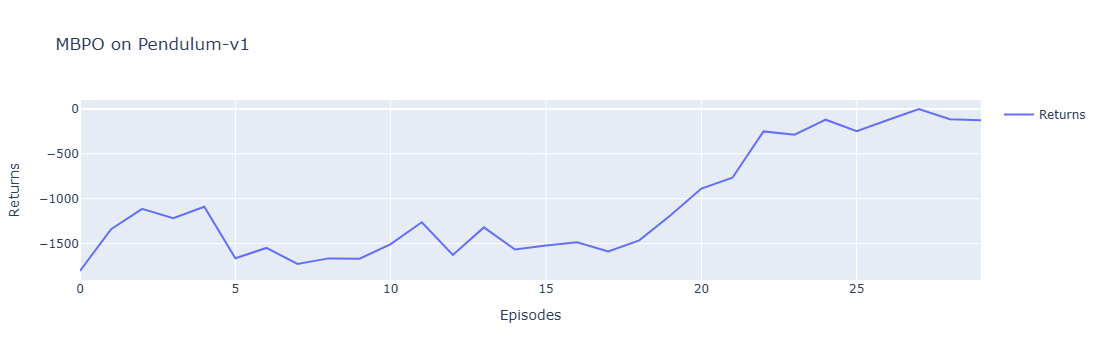

In [1]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('MBPO_Pendulum-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='MBPO on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

*相比 **无模型** 的强化学习算法，基于模型的方法 **MBPO** 在样本效率上要高
虽然这里的效果不如 **PETS** 算法优秀，但是在许多更加复杂的环境中（如 Hopper 和 HalfCheetah） **MBPO** 的表现远远好于 **PETS** 算法*